**Transfer Learning** 
 
Entrenar redes neuronales convolucionales (CNNs) puede tomar mucho tiempo y requiere grandes cantidades de datos. Sin embargo, gran parte de ese tiempo se dedica a aprender los mejores filtros de bajo nivel que una red usa para extraer patrones de las imágenes. Surge entonces una pregunta natural: ¿podemos usar una red neuronal entrenada en un conjunto de datos y adaptarla para clasificar imágenes diferentes sin necesidad de entrenar todo el proceso desde cero?  

A este enfoque se le llama *aprendizaje por transferencia*, porque transferimos parte del conocimiento de un modelo de red neuronal a otro. En el aprendizaje por transferencia normalmente se parte de un modelo preentrenado, el cual ya ha sido entrenado en un gran conjunto de imágenes, como ImageNet. Estos modelos ya hacen un buen trabajo extrayendo distintas características de imágenes genéricas, y en muchos casos basta con construir un clasificador sobre esas características extraídas para obtener buenos resultados.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

from pytorchcv import train, plot_results, display_dataset, train_long, check_image_dir

## Conjunto de datos de Gatos vs. Perros  

En esta unidad resolveremos un problema de la vida real: clasificar imágenes de gatos y perros. Para ello utilizaremos el [Conjunto de datos de Gatos vs. Perros de Kaggle](https://www.kaggle.com/c/dogs-vs-cats), que también puede descargarse [desde Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765).  

Descarguemos este conjunto de datos y extráigámoslo en el directorio `data` (¡este proceso puede tardar algún tiempo!).

In [2]:
if not os.path.exists('data/kagglecatsanddogs_5340.zip'):
    !wget -P data https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [3]:
import zipfile
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

Unfortunately, there are some corrupt image files in the dataset. We need to do quick cleaning to check for corrupted files. In order not to clobber this tutorial, we moved the code to verify dataset into a module.

In [4]:
check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Next, let's load the images into PyTorch dataset, converting them to tensors and doing some normalization. We will apply std_normalize transform to bring images to the range expected by pre-trained VGG network:

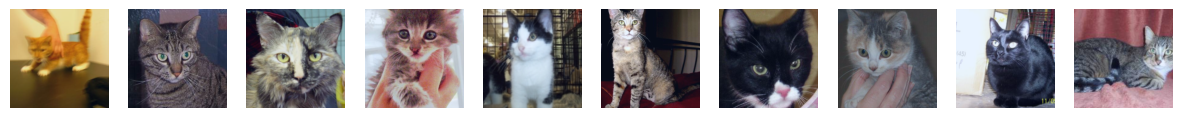

In [5]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        std_normalize])
dataset = torchvision.datasets.ImageFolder('data/PetImages',transform=trans)
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])

display_dataset(dataset)

## Modelos preentrenados  

Existen muchos modelos preentrenados disponibles dentro del módulo `torchvision`, y aún más modelos pueden encontrarse en Internet. Veamos cómo se puede cargar y utilizar el modelo más simple, VGG-16:

In [6]:
from torchvision.models import VGG16_Weights

# Load VGG-16 with pretrained ImageNet weights
vgg = torchvision.models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

sample_image = dataset[0][0].unsqueeze(0)
res = vgg(sample_image)
print(res[0].argmax())

tensor(281)


El resultado que hemos obtenido es un número correspondiente a una clase de `ImageNet`, la cual se puede consultar [aquí](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). Podemos usar el siguiente código para cargar automáticamente esta tabla de clases y devolver el resultado:


In [7]:
import json, requests
class_map = json.loads(requests.get("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json").text)
class_map = { int(k) : v for k,v in class_map.items() }

class_map[res[0].argmax().item()]

['n02123045', 'tabby']

Let's also see the architecture of the VGG-16 network:

In [8]:
!pip install torchsummary

In [12]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = vgg.to(device)   # move model to device

# Call summary with correct input shape (no batch dimension)
summary(vgg, (3, 224, 224), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Además de la capa que ya conocemos, también existe otro tipo de capa llamada **Dropout**. Estas capas actúan como una técnica de **regularización**. La regularización introduce ligeras modificaciones en el algoritmo de aprendizaje para que el modelo generalice mejor. Durante el entrenamiento, las capas de dropout descartan cierta proporción (alrededor del 30%) de las neuronas de la capa anterior, y el entrenamiento se realiza sin ellas. Esto ayuda a que el proceso de optimización salga de mínimos locales y a distribuir el poder decisivo entre diferentes caminos neuronales, lo que mejora la estabilidad general de la red.

## Cálculos en GPU

Las redes neuronales profundas, como VGG-16 y otras arquitecturas más modernas, requieren bastante poder computacional para ejecutarse. Por ello, tiene sentido utilizar aceleración por GPU, si está disponible. Para hacerlo, necesitamos mover explícitamente todos los tensores involucrados en el cálculo a la GPU.

La forma habitual de hacerlo es comprobar la disponibilidad de la GPU en el código y definir la variable `device`, que apunta al dispositivo de cómputo, ya sea GPU o CPU.

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on device = {}'.format(device))

vgg.to(device)
sample_image = sample_image.to(device)

vgg(sample_image).argmax()

Doing computations on device = cuda


tensor(282, device='cuda:0')

## Extracting VGG features

If we want to use VGG-16 to extract features from our images, we need the model without final classification layers. In fact, this "feature extractor" can be obtained using `vgg.features` method:

torch.Size([1, 512, 7, 7])


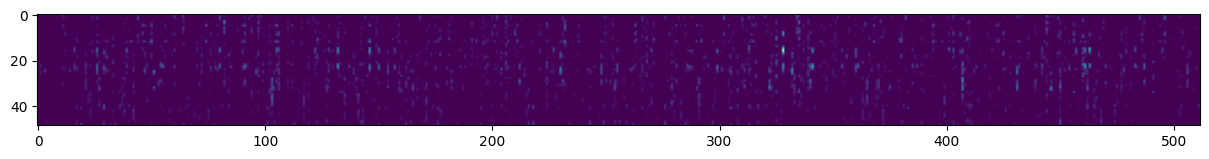

In [14]:
res = vgg.features(sample_image).cpu()
plt.figure(figsize=(15,3))
plt.imshow(res.detach().view(512,-1).T)
print(res.size())

The dimension of feature tensor is 512x7x7, but in order to visualize it we had to reshape it to 2D form.

Now let's try to see if those features can be used to classify images. Let's manually take some portion of images (800 in our case), and pre-compute their feature vectors. We will store the result in one big tensor called `feature_tensor`, and also labels into `label_tensor`:

In [15]:
bs = 8
dl = torch.utils.data.DataLoader(dataset,batch_size=bs,shuffle=True)
num = bs*100
feature_tensor = torch.zeros(num,512*7*7).to(device)
label_tensor = torch.zeros(num).to(device)
i = 0
for x,l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(device))
        feature_tensor[i:i+bs] = f.view(bs,-1)
        label_tensor[i:i+bs] = l
        i+=bs
        print('.',end='')
        if i>=num:
            break

....................................................................................................

Ahora podemos definir `vgg_dataset`, que toma los datos de este tensor, los divide en conjuntos de entrenamiento y prueba usando la función `random_split`, y entrena una pequeña red clasificador densa de una sola capa sobre las característic


In [16]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor,label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset,[700,100])

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=32)

net = torch.nn.Sequential(torch.nn.Linear(512*7*7,2),torch.nn.LogSoftmax(dim=1)).to(device)

history = train(net,train_loader,test_loader)

Epoch  0, Train acc=0.907, Val acc=0.980, Train loss=0.071, Val loss=0.103
Epoch  1, Train acc=0.983, Val acc=0.980, Train loss=0.014, Val loss=0.053
Epoch  2, Train acc=0.984, Val acc=0.970, Train loss=0.018, Val loss=0.029
Epoch  3, Train acc=0.993, Val acc=0.980, Train loss=0.005, Val loss=0.030
Epoch  4, Train acc=0.999, Val acc=0.980, Train loss=0.000, Val loss=0.007
Epoch  5, Train acc=1.000, Val acc=0.970, Train loss=0.000, Val loss=0.086
Epoch  6, Train acc=0.999, Val acc=0.980, Train loss=0.000, Val loss=0.010
Epoch  7, Train acc=1.000, Val acc=0.980, Train loss=0.000, Val loss=0.013
Epoch  8, Train acc=0.999, Val acc=0.970, Train loss=0.000, Val loss=0.222
Epoch  9, Train acc=0.999, Val acc=0.970, Train loss=0.001, Val loss=0.046


¡El resultado es excelente! Podemos distinguir entre un gato y un perro con casi un 98% de probabilidad. Sin embargo, solo hemos probado este enfoque en un pequeño subconjunto de todas las imágenes, porque la extracción manual de características parece tomar mucho tiempo.

## Aprendizaje por transferencia usando una red VGG

También podemos evitar el pre-cálculo manual de las características utilizando la red VGG-16 original completa durante el entrenamiento. Veamos la estructura del objeto VGG-16:


In [17]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Puedes ver que la red contiene:
* un extractor de características (`features`), compuesto por varias capas convolucionales y de pooling  
* una capa de promedio de pooling (`avgpool`)  
* un `classifier` final, que consiste en varias capas densas y transforma 25088 características de entrada en 1000 clases (que es el número de clases en ImageNet)  

Para entrenar el modelo de extremo a extremo que clasificará nuestro conjunto de datos, necesitamos:  
* **reemplazar el clasificador final** por uno que produzca el número requerido de clases. En nuestro caso, podemos usar una capa `Linear` con 25088 entradas y 2 neuronas de salida.  
* **congelar los pesos del extractor convolucional de características**, de manera que no se entrenen. Se recomienda realizar este congelamiento inicialmente, porque de lo contrario la capa clasificador no entrenada puede destruir los pesos preentrenados originales del extractor convolucional. El congelamiento de los pesos se logra configurando la propiedad `requires_grad` de todos los parámetros en `False`.  


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reload a fresh VGG16 with pretrained weights
vgg = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)

# Replace only the last layer in classifier
in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(in_features, 2)

# Freeze convolutional feature extractor
for p in vgg.features.parameters():
    p.requires_grad = False

# Move model to device
vgg = vgg.to(device)

# Print summary (match the device explicitly!)
summary(vgg, (3, 244, 244), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 244, 244]           1,792
              ReLU-2         [-1, 64, 244, 244]               0
            Conv2d-3         [-1, 64, 244, 244]          36,928
              ReLU-4         [-1, 64, 244, 244]               0
         MaxPool2d-5         [-1, 64, 122, 122]               0
            Conv2d-6        [-1, 128, 122, 122]          73,856
              ReLU-7        [-1, 128, 122, 122]               0
            Conv2d-8        [-1, 128, 122, 122]         147,584
              ReLU-9        [-1, 128, 122, 122]               0
        MaxPool2d-10          [-1, 128, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]         295,168
             ReLU-12          [-1, 256, 61, 61]               0
           Conv2d-13          [-1, 256, 61, 61]         590,080
             ReLU-14          [-1, 256,

Este modelo contiene alrededor de 15 millones de parámetros totales, pero solo ~50 000 de ellos son entrenables: esos corresponden a los pesos de la capa de clasificación. Esto es conveniente, porque podemos ajustar un número pequeño de parámetros con una cantidad menor de ejemplos.

Ahora entrenemos el modelo usando nuestro conjunto de datos original. Este proceso tomará bastante tiempo, así que usaremos la función `train_long`, que imprimirá algunos resultados intermedios sin esperar al final de cada época. ¡Se recomienda encarecidamente ejecutar este entrenamiento en una máquina con GPU habilitada!

In [41]:
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])
train_loader = torch.utils.data.DataLoader(trainset,batch_size=16)
test_loader = torch.utils.data.DataLoader(testset,batch_size=16)

train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.8125, train loss = 0.03741651773452759
Epoch 0, minibatch 90: train acc = 0.5281593406593407, train loss = 603118715.7802198
Epoch 0, minibatch 180: train acc = 0.518646408839779, train loss = 30347121884.640884
Epoch 0, minibatch 270: train acc = 0.5196033210332104, train loss = 229128977162.39114


KeyboardInterrupt: 

¡Parece que hemos obtenido un clasificador de gatos vs. perros con una precisión razonable!  
¡Guardémoslo para usarlo en el futuro!

In [32]:
torch.save(vgg.state_dict(), "data/cats_dogs.pth")

Podemos cargar el modelo desde el archivo en cualquier momento. Esto puede resultar útil en caso de que el próximo experimento dañe el modelo, ya que no tendrías que volver a empezar desde cero.

### ¿Qué es `state_dict` en PyTorch?  

En PyTorch, un **`state_dict`** es un diccionario que mapea los nombres de las capas a sus tensores (pesos y sesgos).  

Ejemplo para una red pequeña:  

```
model = torch.nn.Linear(10, 2)
print(model.state_dict())
```

Salida (simplificada):  

```
OrderedDict([
  ('weight', tensor([...])) ,   # matriz de pesos (2,10)
  ('bias',   tensor([...]))     # vector de sesgos (2,)
])
```

---

### ¿Por qué es importante?
- Con `torch.save(model.state_dict(), "file.pth")` guardamos **solo los parámetros**, no todo el objeto del modelo.  
- Más tarde, podemos recrear la arquitectura del modelo y restaurar sus pesos con:  

```
model.load_state_dict(torch.load("file.pth"))
```

---

✅ **Resumen**  
- `state_dict` = diccionario con pesos y sesgos del modelo.  
- Ventaja → es portable, más seguro y funciona entre distintas versiones de PyTorch.  
- Desventaja → necesitas recrear la arquitectura del modelo antes de cargar los pesos.


In [43]:
vgg = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)
in_features = vgg.classifier[6].in_features
vgg.classifier[6] = torch.nn.Linear(in_features, 2)
vgg.load_state_dict(torch.load("data/cats_dogs.pth", map_location="cpu"))

<All keys matched successfully>

## Ajuste fino en aprendizaje por transferencia

En la sección anterior, entrenamos únicamente la capa final de clasificación para clasificar imágenes en nuestro propio conjunto de datos. Sin embargo, no reentrenamos el extractor de características, por lo que nuestro modelo dependía de las características aprendidas previamente con datos de ImageNet. Si los objetos de tu conjunto de datos difieren visualmente de las imágenes comunes de ImageNet, esta combinación de características podría no ser la más adecuada. Por lo tanto, tiene sentido comenzar a entrenar también las capas convolucionales.

Para lograrlo, podemos descongelar los parámetros de los filtros convolucionales que habíamos congelado previamente.  

> **Nota:** Es importante congelar los parámetros primero y entrenar durante varias épocas con el fin de estabilizar los pesos en la capa de clasificación. Si comienzas de inmediato a entrenar la red de extremo a extremo con los parámetros descongelados, es probable que los grandes errores destruyan los pesos preentrenados en las capas convolucionales.

In [44]:
for p in vgg.features.parameters():
    p.requires_grad = False
for p in vgg.features[24:].parameters():   # VGG-16 block5 starts around index 24
    p.requires_grad = True

In [45]:
optimizer = torch.optim.AdamW([
    {"params": vgg.features[24:].parameters(),      "lr": 1e-5},
    {"params": vgg.classifier[6].parameters(),      "lr": 1e-3},
], weight_decay=1e-4)

Después de descongelar, podemos realizar algunas épocas adicionales de entrenamiento. También se puede seleccionar una tasa de aprendizaje más baja, con el fin de minimizar el impacto sobre los pesos preentrenados. Sin embargo, incluso con una tasa de aprendizaje baja, es de esperar que la precisión disminuya al inicio del entrenamiento, hasta alcanzar finalmente un nivel ligeramente superior al obtenido en el caso de mantener los pesos fijos.  

> **Nota:** Este entrenamiento es mucho más lento, porque necesitamos propagar gradientes hacia atrás a través de muchas capas de la red. Es recomendable observar los primeros minibatches para ver la tendencia y, si es necesario, detener el cómputo.


In [46]:
vgg = vgg.to(device)
train_long(
    vgg, train_loader, test_loader,
    loss_fn=nn.CrossEntropyLoss(),
    epochs=1, print_freq=90,
    optimizer=optimizer
)

Epoch 0, minibatch 0: train acc = 1.0, train loss = 0.0
Epoch 0, minibatch 90: train acc = 0.9718406593406593, train loss = 12.67152086195055
Epoch 0, minibatch 180: train acc = 0.9744475138121547, train loss = 9.894654669155733
Epoch 0, minibatch 270: train acc = 0.978090405904059, train loss = 8.04548583083487
Epoch 0, minibatch 360: train acc = 0.9797437673130194, train loss = 7.11852452497403
Epoch 0, minibatch 450: train acc = 0.9792128603104213, train loss = 6.570915543583703
Epoch 0, minibatch 540: train acc = 0.9795517560073937, train loss = 6.1826731457948245
Epoch 0, minibatch 630: train acc = 0.9794968304278923, train loss = 5.842194232245443
Epoch 0, minibatch 720: train acc = 0.9797156726768377, train loss = 5.388096231362691
Epoch 0, minibatch 810: train acc = 0.9796547472256474, train loss = 5.206766939927559
Epoch 0, minibatch 900: train acc = 0.9787735849056604, train loss = 4.995052697523585


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 0, minibatch 990: train acc = 0.9783678102926338, train loss = 4.832036177156912
Epoch 0, minibatch 1080: train acc = 0.9779717853839038, train loss = 4.591417452012026
Epoch 0, minibatch 1170: train acc = 0.9783838599487618, train loss = 4.478806675651152
Epoch 0 done, validation acc = 0.9869947979191677, validation loss = 1.172832902692327


## Otros modelos de visión por computador

VGG-16 es una de las arquitecturas más simples de visión por computador. El paquete `torchvision` ofrece muchas más redes preentrenadas. Entre las más utilizadas se encuentran las arquitecturas **ResNet**, desarrolladas por Microsoft, y **Inception**, desarrollada por Google.  

Por ejemplo, exploremos la arquitectura del modelo más sencillo de la familia ResNet: **ResNet-18**. (ResNet es una familia de modelos con diferentes profundidades; puedes experimentar con ResNet-151 si quieres ver cómo luce un modelo realmente profundo).


In [47]:
resnet = torchvision.models.resnet18()
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Como puedes ver, el modelo contiene los mismos bloques fundamentales: un extractor de características y un clasificador final (`fc`). Esto nos permite usar este modelo de la misma manera en que hemos utilizado VGG-16 para el aprendizaje por transferencia. Puedes experimentar con el código anterior usando diferentes modelos de ResNet como base y observar cómo cambia la precisión.

## Normalización por lotes (Batch Normalization)

Esta red contiene otro tipo de capa: **Batch Normalization**.  
La idea de la normalización por lotes es llevar los valores que fluyen a través de la red neuronal al intervalo adecuado. Generalmente, las redes neuronales funcionan mejor cuando todos los valores están en el rango [-1,1] o [0,1], y por eso escalamos/normalizamos los datos de entrada en consecuencia.  

Sin embargo, durante el entrenamiento de una red profunda, puede suceder que los valores se salgan significativamente de ese rango, lo que dificulta el entrenamiento. La capa de batch normalization calcula el promedio y la desviación estándar de todos los valores del minibatch actual y los usa para normalizar la señal antes de pasarla a través de una capa de la red neuronal. Esto mejora significativamente la estabilidad de las redes profundas.


## Conclusión

Usando aprendizaje por transferencia pudimos armar rápidamente un clasificador para nuestra tarea personalizada de clasificación de objetos y lograr una alta precisión. Sin embargo, este ejemplo no fue completamente justo, porque la red original VGG-16 ya estaba preentrenada para reconocer gatos y perros, por lo que en realidad solo reutilizamos la mayoría de los patrones que ya estaban presentes en la red. En dominios más específicos o exóticos, como detectar detalles en una línea de producción o clasificar diferentes hojas de árboles, se puede esperar una precisión más baja.

También podemos notar que las tareas más complejas que estamos resolviendo ahora requieren mayor poder computacional y no pueden resolverse fácilmente en CPU. En la siguiente unidad, intentaremos usar una implementación más liviana para entrenar el mismo modelo con menos recursos de cómputo, lo que resultará en solo una ligera disminución de la precisión.
